### Ejemplo Python

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [15]:
size_model = 1000

# Create true labels - 100 essays with scores 1-4
true_scores = np.random.randint(1, 5, size=size_model)
# Model 
noise = np.random.randint(-1, 2, size=size_model)
pred_scores = np.clip(true_scores + noise, 1, 4)  # Ensure we stay in range 1-4

# Step 2: Create the observed confusion matrix
# This counts how many times true label i was predicted as j
confusion_matrix = pd.crosstab(
    true_scores, 
    pred_scores,
    rownames=['True'],
    colnames=['Predicted']
)

print("Observed Confusion Matrix:")
print(confusion_matrix)

# Step 3: Calculate row and column totals
row_totals = confusion_matrix.sum(axis=1)
col_totals = confusion_matrix.sum(axis=0)
total_samples = confusion_matrix.sum().sum()

print("\nRow totals (distribution of true labels):")
print(row_totals)

print("\nColumn totals (distribution of predictions):")
print(col_totals)
# Step 4: Calculate the expected matrix
# E[i,j] = (row_total[i] × column_total[j]) ÷ total_samples
expected_matrix = np.outer(row_totals, col_totals) / total_samples

# Convert to DataFrame for better display
expected_df = pd.DataFrame(
    expected_matrix,
    index=confusion_matrix.index,
    columns=confusion_matrix.columns
)

expected_df


n_categories = 4
weight_matrix = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        # Note: The indices in the arrays are 0-based, but our categories are 1-based
        # So we use (i+1) and (j+1) in the formula
        weight_matrix[i, j] = ((i+1) - (j+1))**2 / (n_categories-1)**2

# Convert to DataFrame for better display
weight_df = pd.DataFrame(
    weight_matrix,
    index=range(1, n_categories+1),
    columns=range(1, n_categories+1)
)
print("\nWeight Matrix (quadratic penalty for disagreements):")
print(weight_df.round(2))

# Step 6: Calculate weighted observed and expected disagreement
# Convert to numpy arrays for easier matrix operations
O = confusion_matrix.values
E = expected_matrix

# Calculate weighted disagreement values
weighted_observed = np.sum(weight_matrix * O) / total_samples
weighted_expected = np.sum(weight_matrix * E) / total_samples

print(f"\nWeighted observed disagreement: {weighted_observed:.4f}")
print(f"Weighted expected disagreement: {weighted_expected:.4f}")

# Step 7: Calculate Quadratic Weighted Kappa
qwk = 1 - (weighted_observed / weighted_expected)
print(f"\nQuadratic Weighted Kappa: {qwk:.4f}")

Observed Confusion Matrix:
Predicted    1   2   3    4
True                       
1          167  90   0    0
2           86  86  78    0
3            0  73  79   71
4            0   0  99  171

Row totals (distribution of true labels):
True
1    257
2    250
3    223
4    270
dtype: int64

Column totals (distribution of predictions):
Predicted
1    253
2    249
3    256
4    242
dtype: int64

Weight Matrix (quadratic penalty for disagreements):
      1     2     3     4
1  0.00  0.11  0.44  1.00
2  0.11  0.00  0.11  0.44
3  0.44  0.11  0.00  0.11
4  1.00  0.44  0.11  0.00

Weighted observed disagreement: 0.0552
Weighted expected disagreement: 0.2827

Quadratic Weighted Kappa: 0.8047


Sklearn Quadratic Weighted Kappa: 0.8047


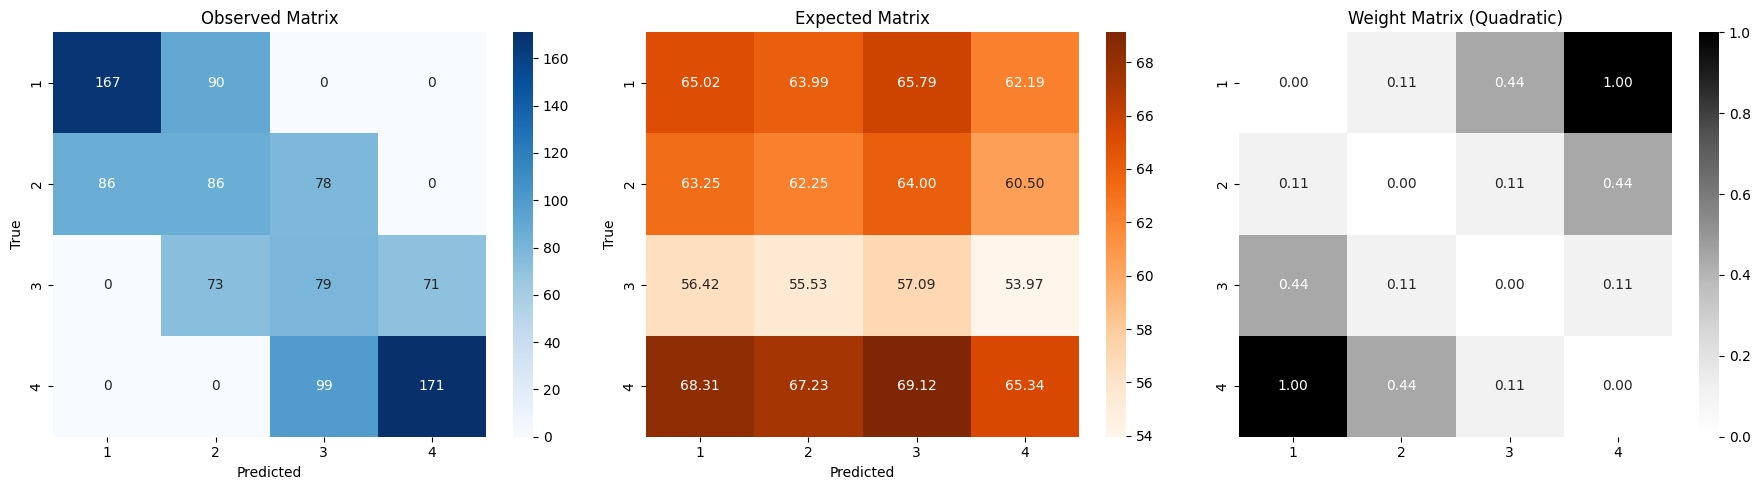

In [23]:
sklearn_qwk = cohen_kappa_score(true_scores, pred_scores, weights='quadratic')
print(f"Sklearn Quadratic Weighted Kappa: {sklearn_qwk:.4f}")

# Step 9: Visualize the matrices for better understanding
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot observed matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Observed Matrix')

# Plot expected matrix
sns.heatmap(expected_df, annot=True, fmt='.2f', cmap='Oranges', ax=axes[1])
axes[1].set_title('Expected Matrix')

# Plot weight matrix
sns.heatmap(weight_df, annot=True, fmt='.2f', cmap='Greys', ax=axes[2])
axes[2].set_title('Weight Matrix (Quadratic)')

plt.tight_layout()
plt.savefig('qwk_matrices.png')
#plt.close()


In [ ]:

# Step 10: Create a scatter plot to visualize the agreement
plt.figure(figsize=(8, 6))

# Add some jitter to see overlapping points
jitter = np.random.normal(0, 0.1, size=len(true_scores))
plt.scatter(true_scores + jitter, pred_scores + jitter, alpha=0.7)

# Add a line for perfect agreement
plt.plot([0.5, 4.5], [0.5, 4.5], 'r--', alpha=0.7)

plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title(f'Agreement Between True and Predicted Scores (QWK = {qwk:.4f})')
plt.xticks([1, 2, 3, 4])
plt.yticks([1, 2, 3, 4])
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('score_agreement.png')
#plt.close()

print("\nExplaining the QWK value:")
if qwk > 0.8:
    print("QWK > 0.8: Almost perfect agreement")
elif qwk > 0.6:
    print("QWK 0.6-0.8: Substantial agreement")
elif qwk > 0.4:
    print("QWK 0.4-0.6: Moderate agreement")
elif qwk > 0.2:
    print("QWK 0.2-0.4: Fair agreement")
elif qwk > 0:
    print("QWK 0-0.2: Slight agreement")
else:
    print("QWK ≤ 0: Poor agreement (worse than random)")